# Классификация обзоров с использованием BERT

[Пример от Google](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Данные

In [2]:
train_data = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None, names=['text', 'positive'])
train_data.head()

,text,positive
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [3]:
test_data = pd.read_csv('products_sentiment_test.tsv', sep='\t')
test_data.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [4]:
train_reviews, validate_reviews, train_target, validate_target = train_test_split(train_data.text.values, train_data.positive.values, test_size=0.05)

In [5]:
BATCH_SIZE = 16

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    [tf.convert_to_tensor(x, dtype=tf.string, name='inputs') for x in train_reviews], 
    train_target,
)).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    [tf.convert_to_tensor(x, dtype=tf.string, name='inputs') for x in validate_reviews],
    validate_target,
)).batch(BATCH_SIZE)

## Модель

In [7]:
BERT_ENCODER = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
BERT_PREPROCESSOR = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [8]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(BERT_PREPROCESSOR, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(BERT_ENCODER, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [9]:
classifier_model = build_classifier_model()

## Дообучение на отзывах

In [10]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [11]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [12]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [13]:
history = classifier_model.fit(x=train_dataset,
                               validation_data=validate_dataset,
                               epochs=epochs)

Epoch 1/2
119/119 [==============================] - 524s 4s/step - loss: 0.4682 - binary_accuracy: 0.7637 - val_loss: 0.2097 - val_binary_accuracy: 0.9100
Epoch 2/2
119/119 [==============================] - 509s 4s/step - loss: 0.1837 - binary_accuracy: 0.9332 - val_loss: 0.2066 - val_binary_accuracy: 0.9300


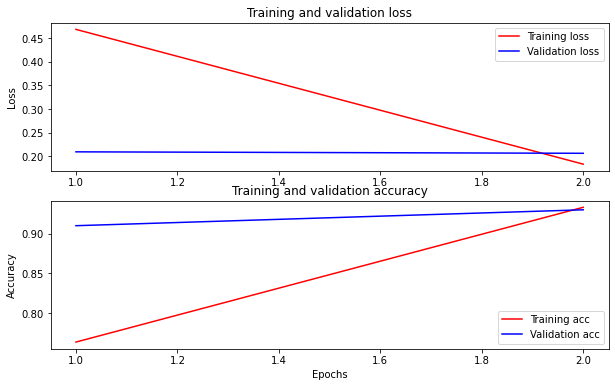

In [14]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Классификация тестовой выборки

In [15]:
results = tf.sigmoid(classifier_model(tf.constant(test_data.text.values)))

In [16]:
result_data = test_data.copy()
result_data['y'] = np.int8(np.round(results.numpy()))

In [17]:
result_data.head()

,Id,text,y
0,0,"so , why the small digital elph , rather than ...",1
1,1,3/4 way through the first disk we played on it...,0
2,2,better for the zen micro is outlook compatibil...,1
3,3,6 . play gameboy color games on it with goboy .,1
4,4,"likewise , i 've heard norton 2004 professiona...",1


In [18]:
result_data.to_csv('my_result.bert.csv', columns=['Id', 'y'], index=False)